<a href="https://colab.research.google.com/github/NatSy77/projet_7/blob/main/P7_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implémentez un modèle de scoring #modelisation

## Importation

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.5/637.5 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [4]:
!pip install --upgrade scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 47.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [5]:
!pip install --upgrade threadpoolctl scikit-learn imbalanced-learn xgboost

In [6]:
import sklearn
import imblearn
import xgboost

print("scikit-learn version:", sklearn.__version__)
print("imblearn version:", imblearn.__version__)
print("xgboost version:", xgboost.__version__)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7daf8deb7b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


scikit-learn version: 1.6.0
imblearn version: 0.13.0
xgboost version: 2.1.3


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# List files available
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/"))

['app_train.csv', 'app_test.csv']


In [9]:
#importation fichier
app_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 242)


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,True,False,True,False,1,False
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,False,False,False,False,False,True,False,0,False
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,0,False
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,0,False
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,0,False


In [10]:
# importation fichier
app_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (307511, 242)


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,True,False,True,False,1,False
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,False,False,False,False,False,True,False,0,False
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,0,False
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,0,False
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,0,False


## Exploration

In [11]:
app_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


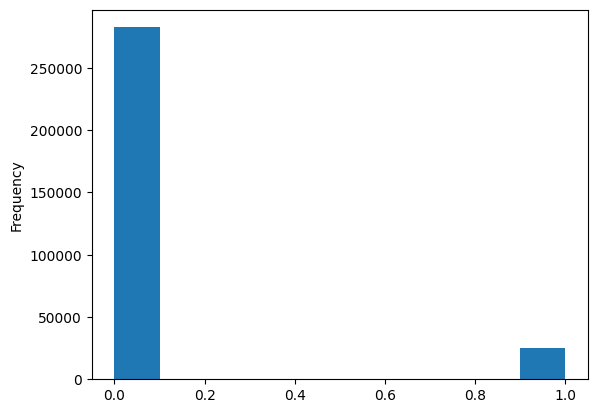

In [12]:
app_train['TARGET'].astype(int).plot.hist();

In [13]:
# Number of each type of column
app_train.dtypes.value_counts()

,count
bool,132
float64,66
int64,44


In [14]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 242)
Testing Features shape:  (307511, 242)


# Modélisation

### Préparation de l'environement

In [15]:
!pip install mlflow pyngrok

In [16]:
import os
from pyngrok import ngrok
import mlflow
import mlflow.sklearn  # Pour enregistrer les modèles scikit-learn

In [17]:
mlflow_directory = "/content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow"
os.makedirs(mlflow_directory, exist_ok=True)
mlflow.set_tracking_uri(f"file://{mlflow_directory}")

### Chargement des données et préparation

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chargement des données
if 'TARGET' in app_train.columns:
    train = app_train.drop(columns=['TARGET'])
    target = app_train['TARGET']
else:
    train = app_train.copy()
    target = None

# Vérification des valeurs manquantes
if train.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='median')
    train = imputer.fit_transform(train)
else:
    train = train.values  # Conversion explicite si c'est un DataFrame

# Mise à l'échelle des caractéristiques
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)

# Diviser les données en ensembles d'entraînement et de test (si `target` est défini)
if target is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        train, target, test_size=0.2, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = None, None, None, None
    print("Attention : Aucune étiquette ('target') n'a été fournie.")

### Initialisation de MLflow

In [19]:
import mlflow
import os

# Créer le répertoire mlflow s'il n'existe pas
mlflow_directory = "/content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow"
os.makedirs(mlflow_directory, exist_ok=True)

# Définir l'URI de suivi MLflow
mlflow.set_tracking_uri(f"file://{mlflow_directory}")

# Définir l'expérience
mlflow.set_experiment("Multi-Model Experiment avec SMOTE")

2025/01/24 09:39:07 INFO mlflow.tracking.fluent: Experiment with name 'Multi-Model Experiment avec SMOTE' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///content/drive/MyDrive/Colab '
 'Notebooks/DS_projet_7/mlflow/161128569744698711'), creation_time=1737711547169, experiment_id='161128569744698711', last_update_time=1737711547169, lifecycle_stage='active', name='Multi-Model Experiment avec SMOTE', tags={}>

In [20]:
input_example = np.array([X_train[1]])  # Exemple basé sur une ligne des données d'entraînement

### Préparation des outils et des données
Cette première étape configure les outils nécessaires, notamment pour gérer les classes déséquilibrées avec SMOTE et pour normaliser les données.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer

# Gérer les classes déséquilibrées avec SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalisation des données
scaler = MinMaxScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

### Ajout d’une pipeline et Optimisation des hyperparamètres
Créer une pipeline pour standardiser le traitement, incluant SMOTE, la normalisation, et le modèle.

Intégration de RandomizedSearchCV pour trouver les meilleurs hyperparamètres d’un modèle dans une pipeline.

In [22]:
import time
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from mlflow.sklearn import load_model, log_model
from joblib import Parallel, delayed
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

#### hyperparamètres

In [23]:
# Dictionnaire des modèles avec leurs hyperparamètres
models_with_params = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            'model__C': [0.1, 1, 10],
            'model__solver': ['liblinear']
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'model__n_estimators': [50, 100],
            'model__max_depth': [10, 20]
        }
    },
    #"XGBoost": {
        #"model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_jobs=-1, tree_method='hist'),
        #"params": {
            #'model__n_estimators': [50, 100, 150],
            #'model__learning_rate': [0.05, 0.1, 0.2],
            #'model__max_depth': [3, 5, 7],
            #'model__subsample': [0.8, 1.0],
            #'model__colsample_bytree': [0.8, 1.0],
            #'model__gamma': [0, 1]
        #}
    #},
    "GradientBoosting": {
        "model": HistGradientBoostingClassifier(random_state=42),
        "params": {
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_iter': [50, 100, 150],
            'model__max_depth': [3, 5, 7],
            'model__min_samples_leaf': [20, 50]
        }
    }
}

#### score métier

In [24]:
def custom_cost_function(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcul d'un score métier basé sur le coût des erreurs.

    Args:
    y_true (array-like): Valeurs réelles.
    y_pred (array-like): Prédictions du modèle.
    cost_fn (int): Coût d'un faux négatif.
    cost_fp (int): Coût d'un faux positif.

    Returns:
    float: Coût total des erreurs.
    """
    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût total
    total_cost = (cost_fp * fp) + (cost_fn * fn)
    return total_cost

#### RandomizedSearchCV

In [25]:
def train_pipeline(model_name, model, params, X_train, y_train):
    print(f"\nEntraînement du pipeline pour {model_name}...")
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    #grid_search = GridSearchCV(
        #pipeline,
        #param_grid=params,  # Utiliser 'params' ici
        #scoring='f1',
        #cv=5,
        #n_jobs=-1
    #)
    random_search = RandomizedSearchCV(
        estimator=pipeline, # Utiliser 'pipeline' ici
        param_distributions=params,  # Utiliser 'params' ici
        n_iter=20,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    #grid_search.fit(X_train, y_train)
    joblib.dump(random_search.best_estimator_, f'pipeline_{model_name}.pkl')
    print(f"Pipeline pour {model_name} sauvegardé sous le nom pipeline_{model_name}.pkl")
    return random_search.best_params_

#### training

In [26]:
if __name__ == "__main__":
    # Vérifier si les données sont disponibles
    if X_train is not None and y_train is not None:
        results = {}

        # Parcourir les modèles du dictionnaire et les entraîner un par un
        for model_name, model_data in models_with_params.items():
            print(f"Entraînement du modèle : {model_name}")

            best_params = train_pipeline(
                model_name=model_name,
                model=model_data["model"],
                params=model_data["params"],
                X_train=X_train,
                y_train=y_train
            )

            results[model_name] = best_params

        # Afficher les résultats finaux
        print("\nRésultats finaux :")
        for model, params in results.items():
            print(f"{model}: {params}")
    else:
        print("Erreur : Les données d'entraînement ne sont pas disponibles.")

Entraînement du modèle : LogisticRegression

Entraînement du pipeline pour LogisticRegression...
Pipeline pour LogisticRegression sauvegardé sous le nom pipeline_LogisticRegression.pkl
Entraînement du modèle : RandomForest

Entraînement du pipeline pour RandomForest...
Pipeline pour RandomForest sauvegardé sous le nom pipeline_RandomForest.pkl
Entraînement du modèle : GradientBoosting

Entraînement du pipeline pour GradientBoosting...
Pipeline pour GradientBoosting sauvegardé sous le nom pipeline_GradientBoosting.pkl

Résultats finaux :
LogisticRegression: {'model__solver': 'liblinear', 'model__C': 10}
RandomForest: {'model__n_estimators': 100, 'model__max_depth': 20}
GradientBoosting: {'model__min_samples_leaf': 20, 'model__max_iter': 150, 'model__max_depth': 7, 'model__learning_rate': 0.1}


### Boucle sur plusieurs modèles avec journalisation MLflow
Cette étape inclut les modèles supplémentaires et enregistre chaque expérimentation dans MLflow.

In [27]:
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import shap
import gc

In [28]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [29]:
import sklearn
import xgboost
print(f"scikit-learn version: {sklearn.__version__}")
print(f"xgboost version: {xgboost.__version__}")

scikit-learn version: 1.6.0
xgboost version: 2.1.3


In [30]:
# Liste des modèles
models = {
    "DummyClassifier": DummyClassifier(strategy="most_frequent"),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "GradientBoosting": HistGradientBoostingClassifier(random_state=42)
}

In [31]:
# Liste pour stocker les courbes ROC
roc_curves = []

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
# Répertoire pour les sorties
output_dir = "mlflow_outputs"
os.makedirs(output_dir, exist_ok=True)

# Boucle sur chaque modèle
for model_name, model in models.items():
    start_time = time.time()

    # === Définir la pipeline ===
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    # === Entraîner la pipeline ===
    pipeline.fit(X_train, y_train)

    # Sauvegarder la pipeline localement
    pipeline_path = os.path.join(output_dir, f'pipeline_{model_name}.pkl')
    joblib.dump(pipeline, pipeline_path)

    # === Prédictions ===
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    # === Calcul des métriques ===
    total_cost = custom_cost_function(y_test, y_pred, cost_fn=10, cost_fp=1)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # === MLflow : Enregistrement ===
    with mlflow.start_run(run_name=model_name):
        # Paramètres et métriques
        mlflow.log_param("model_name", model_name)
        if hasattr(model, "n_estimators"):
            mlflow.log_param("n_estimators", model.n_estimators)
        if hasattr(model, "max_depth"):
            mlflow.log_param("max_depth", model.max_depth)
        if hasattr(model, "learning_rate"):
            mlflow.log_param("learning_rate", model.learning_rate)

        # Métriques de performance
        mlflow.log_metric("custom_cost", total_cost)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        if auc_roc is not None:
            mlflow.log_metric("auc_roc", auc_roc)

        # Ajout de l'ID du commit Git
        try:
            git_commit = !git rev-parse HEAD
            mlflow.log_param("git_commit", git_commit[0])
        except Exception as e:
            print(f"Impossible de récupérer l'ID du commit : {e}")

        # Journaliser la pipeline dans MLflow
        input_example = pd.DataFrame(X_train[:1])  # Exemple d'entrée pour le modèle
        log_model(
            sk_model=pipeline,
            artifact_path="model_pipeline",
            input_example=input_example
        )

        # === Courbe ROC ===
        if y_prob is not None:
            plt.figure()
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve - {model_name}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")
            roc_curve_path = os.path.join(output_dir, f"roc_curve_{model_name}.png")
            plt.savefig(roc_curve_path)
            plt.close()
            mlflow.log_artifact(roc_curve_path)

        # Enregistrer le temps d'exécution
        elapsed_time = time.time() - start_time
        mlflow.log_metric("training_time", elapsed_time)

    print(f"Modèle {model_name} journalisé avec succès.")

Modèle DummyClassifier journalisé avec succès.
Modèle LogisticRegression journalisé avec succès.
Modèle RandomForest journalisé avec succès.
Modèle GradientBoosting journalisé avec succès.


In [ ]:
"""# Boucle sur chaque modèle
for model_name, model in models.items():
    start_time = time.time()

    # Pipeline spécifique au modèle
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)  # Utilise le modèle courant
    ])

    # Ajuster le modèle
    pipeline.fit(X_train, y_train)

    # Sauvegarder la pipeline
    joblib.dump(pipeline, f'pipeline_{model_name}.pkl')
    print(f"Pipeline sauvegardée sous le nom pipeline_{model_name}.pkl")

    # Prédictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    # Calcul du score métier
    total_cost = custom_cost_function(y_test, y_pred, cost_fn=10, cost_fp=1)
    print(f"Coût total pour le modèle {model_name} : {total_cost}")

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Calcul de la courbe ROC pour ce modèle
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        roc_curves.append((fpr, tpr, model_name, roc_auc))

    # Journalisation dans MLflow
    mlflow.end_run()  # Terminer tout ancien run
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model_name", model_name)
        if hasattr(model, "n_estimators"):
            mlflow.log_param("n_estimators", model.n_estimators)
        if hasattr(model, "max_depth"):
            mlflow.log_param("max_depth", model.max_depth)
        if hasattr(model, "learning_rate"):
            mlflow.log_param("learning_rate", model.learning_rate)
        if isinstance(model, HistGradientBoostingClassifier):
            mlflow.log_param("max_iter", model.max_iter)
            mlflow.log_param("min_samples_leaf", model.min_samples_leaf)

        # Journaliser les métriques
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        if auc_roc is not None:
            mlflow.log_metric("auc_roc", auc_roc)

        # Journaliser le modèle
        input_example = pd.DataFrame(X_train[:1])  # Exemple d'entrée
        log_model(
            sk_model=pipeline,
            artifact_path="model_pipeline",
            input_example=input_example
        )

        # Journaliser la courbe ROC dans MLflow
        if y_prob is not None:
            plt.figure()
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve - {model_name}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")
            plt.savefig(f'roc_curve_{model_name}.png')  # Sauvegarde locale
            plt.close()

            mlflow.log_artifact(f'roc_curve_{model_name}.png')

    # Temps d'exécution
    elapsed_time = time.time() - start_time
    print(f"Temps d'exécution pour le modèle {model_name} : {elapsed_time:.2f} secondes")
    mlflow.log_metric("training_time", elapsed_time)

    print(f"Modèle {model_name} terminé et journalisé avec MLflow.")


# Afficher les courbes ROC après la boucle
plt.figure(figsize=(10, 6))
for fpr, tpr, model_name, roc_auc in roc_curves:
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Courbe aléatoire
plt.title('Courbes ROC')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.legend()
plt.show()"""

'# Boucle sur chaque modèle\nfor model_name, model in models.items():\n    start_time = time.time()\n\n    # Pipeline spécifique au modèle\n    pipeline = ImbPipeline(steps=[\n        (\'imputer\', SimpleImputer(strategy=\'median\')),\n        (\'scaler\', MinMaxScaler()),\n        (\'smote\', SMOTE(random_state=42)),\n        (\'model\', model)  # Utilise le modèle courant\n    ])\n\n    # Ajuster le modèle\n    pipeline.fit(X_train, y_train)\n\n    # Sauvegarder la pipeline\n    joblib.dump(pipeline, f\'pipeline_{model_name}.pkl\')\n    print(f"Pipeline sauvegardée sous le nom pipeline_{model_name}.pkl")\n\n    # Prédictions\n    y_pred = pipeline.predict(X_test)\n    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None\n\n    # Calcul du score métier\n    total_cost = custom_cost_function(y_test, y_pred, cost_fn=10, cost_fp=1)\n    print(f"Coût total pour le modèle {model_name} : {total_cost}")\n\n    # Calcul des métriques\n    accuracy = ac

Metriques :
- **F1-Score**
Le F1-score est une métrique qui combine précision et rappel en un seul score harmonique. C'est utile lorsque vous avez un déséquilibre entre les classes, car il pénalise les modèles qui sacrifient l'une au profit de l'autre.

Utilisé lorsque les faux positifs (FP) et faux négatifs (FN) sont également importants.

- **AUC-ROC (Area Under the Curve - Receiver Operating Characteristic)**
L'AUC-ROC mesure la capacité d'un modèle à discriminer entre les classes positives et négatives, en testant différents seuils de probabilité.
Interprétation de l'AUC :
AUC = 1 : Parfaite séparation des classes.
AUC = 0.5 : Modèle aléatoire (aucune capacité de discrimination).
AUC < 0.5 : Mauvais modèle (inversion des classes).

Utile pour comparer des modèles indépendamment d'un seuil spécifique.

- **Précision (Precision)**
La précision mesure la proportion de vrais positifs parmi tous les échantillons prédits comme positifs.

Utile lorsque les faux positifs sont coûteux.

- **Rappel (Recall ou Sensibilité)**
Le rappel mesure la proportion de vrais positifs parmi tous les échantillons qui sont effectivement positifs.

- **Temps de calcul**
mesurer le temps de calcul de chaque modèle

Utile lorsque les faux négatifs sont coûteux.

Précision vs Rappel : Il existe souvent un compromis entre précision et rappel. Une augmentation de l'un peut réduire l'autre.
F1-Score : Trouve un équilibre entre précision et rappel.
AUC-ROC : Évalue la performance globale sur tous les seuils.

En utilisant ces prédictions :

* Précision : Parmi les clients que le modèle dit éligibles, combien le sont vraiment ?
* Rappel : Parmi les clients réellement éligibles, combien le modèle détecte-t-il ?
* F1-Score : Moyenne harmonique de la précision et du rappel.
* AUC-ROC : Mesure la capacité du modèle à distinguer entre les deux classes sur tous les seuils possibles.

Ces métriques permettent de choisir le modèle qui répond le mieux à vos objectifs métier et aux coûts associés aux erreurs de classification.

### Lancer l'interface MLflow UI
Utilisation d'une interface web distante via ngrok(exposée au public), créer un compte et récupérer le token

In [34]:
!ngrok authtoken 2qlJq50YUC2X62MFA1q7qxbILkY_5Dx45MFSwjmUQLvcqSHBU

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [37]:
!mlflow ui --backend-store-uri "file:///content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow" --port 5000 &

[2025-01-24 11:51:02 +0000] [34576] [INFO] Starting gunicorn 23.0.0
[2025-01-24 11:51:02 +0000] [34576] [INFO] Listening at: http://127.0.0.1:5000 (34576)
[2025-01-24 11:51:02 +0000] [34576] [INFO] Using worker: sync
[2025-01-24 11:51:02 +0000] [34577] [INFO] Booting worker with pid: 34577
[2025-01-24 11:51:02 +0000] [34578] [INFO] Booting worker with pid: 34578
[2025-01-24 11:51:03 +0000] [34579] [INFO] Booting worker with pid: 34579
[2025-01-24 11:51:03 +0000] [34580] [INFO] Booting worker with pid: 34580
[2025-01-24 11:52:19 +0000] [34576] [INFO] Handling signal: int
[2025-01-24 11:52:19 +0000] [34579] [INFO] Worker exiting (pid: 34579)
[2025-01-24 11:52:19 +0000] [34578] [INFO] Worker exiting (pid: 34578)
[2025-01-24 11:52:19 +0000] [34580] [INFO] Worker exiting (pid: 34580)
[2025-01-24 11:52:19 +0000] [34577] [INFO] Worker exiting (pid: 34577)
[2025-01-24 11:52:20 +0000] [34576] [INFO] Shutting down: Master


In [36]:
from pyngrok import conf, ngrok

# Définir le token dans la configuration
conf.get_default().auth_token = "2qlJq50YUC2X62MFA1q7qxbILkY_5Dx45MFSwjmUQLvcqSHBU"

# Démarrer le tunnel
public_url = ngrok.connect(5000)
print(f"Interface MLflow accessible à : {public_url}")

Interface MLflow accessible à : NgrokTunnel: "https://6d7e-35-192-58-176.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
# arrêter le tunnel ngrok
#ngrok.disconnect(public_url)

In [ ]:
        """# Assurez-vous que X_train est un DataFrame, sinon utilisez les indices ou noms de colonnes pour l'affichage
        if isinstance(X_train, np.ndarray):
            X_train = pd.DataFrame(X_train, columns=[f"Feature {i}" for i in range(X_train.shape[1])])


        # === Analyse des Feature Importance ===
        if hasattr(model, "feature_importances_"):
            # Graphique des importances globales
            plt.figure(figsize=(10, 6))
            plt.barh(X_train.columns, model.feature_importances_, color="skyblue")
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.title(f"Feature Importance pour {model_name}")
            plt.gca().invert_yaxis()
            feature_importance_path = os.path.join(output_dir, f"{model_name}_feature_importance.png")
            plt.savefig(feature_importance_path)
            plt.close('all')

        elif hasattr(model, "coef_"):
            # Pour les modèles comme LogisticRegression, utilisez les coefficients
            plt.figure(figsize=(10, 6))
            plt.barh(X_train.columns, model.coef_[0], color="skyblue")
            plt.xlabel("Coefficient")
            plt.ylabel("Feature")
            plt.title(f"Feature Importance (coefficients) pour {model_name}")
            plt.gca().invert_yaxis()
            feature_importance_path = os.path.join(output_dir, f"{model_name}_feature_importance.png")
            plt.savefig(feature_importance_path)
            plt.close()


        # === SHAP ===
        try:
            # Échantillonnage pour l’analyse globale
            X_train_sample = X_train[np.random.choice(X_train.shape[0], 1000, replace=False), :]
            X_test_sample = X_test[np.random.choice(X_test.shape[0], 5, replace=False), :]

            # Vérification de compatibilité du modèle
            if isinstance(model, (GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier)):
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(X_test_sample)
            elif hasattr(model, "predict"):
                explainer = shap.Explainer(model, X_train_sample)
                shap_values = explainer(X_test_sample)
            else:
                raise ValueError(f"SHAP non supporté pour le modèle {model_name}")

            # SHAP Summary Plot (global)
            shap.summary_plot(shap_values, X_test_sample, show=False)
            shap_summary_path = os.path.join(output_dir, f"{model_name}_shap_summary.png")
            plt.savefig(shap_summary_path)
            plt.close()
            mlflow.log_artifact(shap_summary_path)

            # SHAP Waterfall Plot (local)
            for i in range(len(X_test_sample)):
                shap.waterfall_plot(shap_values[i], show=False)
                shap_waterfall_path = os.path.join(output_dir, f"{model_name}_shap_waterfall_{i}.png")
                plt.savefig(shap_waterfall_path)
                plt.close()
                mlflow.log_artifact(shap_waterfall_path)

            # Libérer de la mémoire
            del explainer, shap_values
            gc.collect()

        except Exception as e:
            print(f"Erreur avec SHAP pour {model_name}: {e}")"""